# EDA - NoMES


In [1]:
import pandas as pd

changes = pd.read_csv("../Downloads/data_2020.csv",  sep=';')
print(changes['time'])


0           2020/08/02 23:40:03
1           2020/08/02 23:40:03
2           2020/08/02 23:40:03
3           2020/08/02 23:40:03
4           2020/08/02 23:40:03
                   ...         
30371548    2020/08/02 23:40:03
30371549    2020/08/02 23:40:03
30371550    2020/08/02 23:40:03
30371551    2020/08/02 23:40:03
30371552    2020/08/02 23:40:03
Name: time, Length: 30371553, dtype: object


In [2]:
changes = changes[(changes['month'] >= 4)  & (changes['yhour'] <= 3170)]
weather = pd.read_csv("./weather2020.csv", parse_dates= {"time" : ["Vuosi","Kk","Pv", "Klo"]})
for col in weather.columns:
    weather[col] = weather[col].interpolate()


#weather['datetime'] = weather[['Vuosi', 'Kk', 'Pv', 'Klo']].apply(pd.to_datetime, format='%Y-%m-%d %HH:%MM')

In [3]:
changes['time'] = pd.to_datetime(changes['time'])
weather['time'] = pd.to_datetime(weather['time'].dt.strftime('%Y-%m-%d %H:%M'))
changes['time'] = changes['time'].dt.strftime('%Y-%m-%d %H:%M')
changes['time'] = pd.to_datetime(changes['time'])


In [4]:

weather = weather[["time", "Ilman lämpötila (degC)", "Tuulen nopeus (m/s)", "Tuulen suunta (deg)", "Puuskanopeus (m/s)", "Suhteellinen kosteus (%)", "Kastepistelämpötila (degC)"]]
weather

,time,Ilman lämpötila (degC),Tuulen nopeus (m/s),Tuulen suunta (deg),Puuskanopeus (m/s),Suhteellinen kosteus (%),Kastepistelämpötila (degC)
0,2020-04-01 00:00:00,3.1,3.7,277.0,6.2,79.0,-0.2
1,2020-04-01 00:10:00,3.1,2.9,275.0,4.7,79.0,-0.2
2,2020-04-01 00:20:00,3.0,3.7,264.0,6.7,78.0,-0.4
3,2020-04-01 00:30:00,3.1,3.8,278.0,6.7,77.0,-0.5
4,2020-04-01 00:40:00,3.1,4.3,278.0,7.0,76.0,-0.7
...,...,...,...,...,...,...,...
12092,2020-06-23 23:20:00,17.5,2.5,323.0,3.7,69.0,11.8
12093,2020-06-23 23:30:00,17.3,2.5,316.0,3.6,69.0,11.5
12094,2020-06-23 23:40:00,17.2,2.5,321.0,3.5,69.0,11.4
12095,2020-06-23 23:50:00,17.1,2.3,321.0,3.4,69.0,11.4


In [5]:
changes = pd.merge(changes, weather, how='inner', on='time')

In [6]:
print(changes)
# check for missing values (month, days per month)
# lists months and days per month

# expected values = something


def check_missing_values():

    months = changes['month'].unique()

    for m in months:
        print(m)
        month = changes[changes['month'] == m]
        
        print(month['day'].unique())
        
        # compare to expected values
    # return difference


maxspaces = max(changes["bikesAvailable"])

print(changes[changes["bikesAvailable"] == maxspaces])

check_missing_values()

           id  bikesAvailable  spacesAvailable  allowDropoff  isFloatingBike  \
0        1215               0               10             1               0   
1        1213               6                4             1               0   
2        1211              10                0             1               0   
3        1219               0               10             1               0   
4        1217              18                2             1               0   
...       ...             ...              ...           ...             ...   
4790754  1201              16                4             1               0   
4790755   900              10               13             1               0   
4790756   901               4               16             1               0   
4790757  1209               9                1             1               0   
4790758  1207              12                8             1               0   

              state  realTimeData      

In [7]:
print(changes[changes['yday'] == 93])

          id  bikesAvailable  spacesAvailable  allowDropoff  isFloatingBike  \
55473   1215               0               10             1               0   
55474   1213               6                4             1               0   
55475   1211              10                0             1               0   
55476   1219               5                5             1               0   
55477   1217              12                8             1               0   
...      ...             ...              ...           ...             ...   
119961  1201              14                6             1               0   
119962   900               6               14             1               0   
119963   901               4               16             1               0   
119964  1209              13                0             1               0   
119965  1207              16                4             1               0   

             state  realTimeData                tim

In [8]:
# separate stations in their own dataframes

telling_ids = changes['id'].unique()
stations = {}

for i in telling_ids:
    station = changes[changes['id'] == i]
    stations[i] = station

print(len(stations))
print(stations[11]
)

451
         id  bikesAvailable  spacesAvailable  allowDropoff  isFloatingBike  \
296      11               7               15             1               0   
747      11               7               15             1               0   
1198     11               7               15             1               0   
1649     11               7               15             1               0   
2100     11               7               15             1               0   
...      ..             ...              ...           ...             ...   
4788804  11               0               22             1               0   
4789254  11               1               21             1               0   
4789704  11               1               21             1               0   
4790154  11               1               21             1               0   
4790604  11               1               21             1               0   

              state  realTimeData                time  week

In [9]:
# map station names to ids
# clean station names

def clean_names(names):
    # strip and removal of duplicates
    return set([name.strip() for name in names])


station_data = pd.read_csv("../Downloads/tellingit_2017-2021.csv", sep=';')
station_names = station_data[station_data['year'] == 2020]['name'].unique()
station_names = clean_names(station_names)
station_ids = station_data[station_data['year'] == 2020]['id'].unique()

names_ids = {}

for ids in station_ids:
    name = station_data[station_data['id'] == ids].iloc[0]['name']
    names_ids[ids] = name


print(names_ids[11])

Unioninkatu


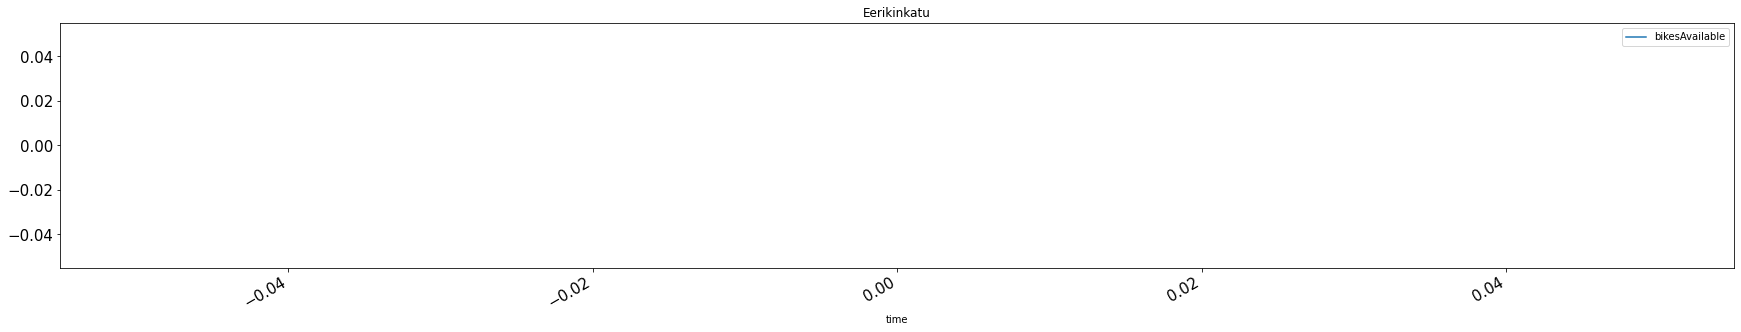

In [10]:
# plot changes per station over time X

import matplotlib.pyplot as plt

def filter_rows(yday: int, station_id: int, min_hour: int, max_hour: int) -> pd.DataFrame():
    yday = yday
    i = station_id
    station = stations[i]

    station = station[station['yday'] == yday]

    if min_hour is not None and max_hour is not None:
        station = station[(station['yhour'] >= min_hour) & (station['yhour'] <= max_hour)]

    return station


def plot_bike_changes(station_id, station):
    title = names_ids[station_id]
    station.plot(x='time', y='bikesAvailable', figsize=(30,5), fontsize=15, title=title)
    plt.savefig(f"img/{title}")

i = 27

station = filter_rows(219, i, None, None)
plot_bike_changes(i, station)


In [11]:
# Primary target: count how many times per day bikes drop to day's minimum

def count_drops(station):
    minbikes = min(station['bikesAvailable'])
    counts = 0
    was_min = False

    for i, row in station.iterrows():
        bikes = row['bikesAvailable'] 

        # drop starts
        if not was_min and bikes == minbikes:
            counts += 1
            was_min = True

        # drop ends
        elif was_min and bikes != minbikes:
            was_min = False

    return counts, minbikes

i = 113
station = filter_rows(219, i, None, None)
print(count_drops(station))
# plot_bike_changes(i, station)

ValueError: min() arg is an empty sequence

In [ ]:
# Secondary target: Count the number of changes
# there is a change if the number of bikes is different than for the previous 5min (doesn't take into account the number of bikes changed)

def count_changes(station):
    counts = 0
    previous = -1

    for i, row in station.iterrows():
        bikes = row['bikesAvailable'] 

        # print(previous, bikes)
        if bikes != previous:
            # found change 
            counts += 1
            previous = bikes

        # print(counts)
    return counts

i = 11
station = filter_rows(218, i, None, None)
print("changes", count_changes(station))
# plot_bike_changes(i, station)

In [12]:
changes = changes.assign(wday=changes['yday'] % 7 + 1)


In [13]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer
from sklearn.preprocessing import MinMaxScaler
import numpy as np


In [14]:
def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["wday"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)

In [15]:
# predict number of bikes
import sklearn
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate, TimeSeriesSplit, cross_val_score

#changes = stations[11]
#changes = changes.assign(wday=changes['yday'] % 7 + 1)
print(changes)
X = changes.drop(["bikesAvailable", "spacesAvailable", "state", "time", "minute", "allowDropoff", "state", "isFloatingBike", "realTimeData"], axis=1)
y = changes["bikesAvailable"]

# print(len(X), len(y))

# test_size requires scikit-learn>=0.24.0
tscv = TimeSeriesSplit(n_splits = 5, gap=288, test_size=288, max_train_size=10000)
# print(tscv)


# scores = cross_val_score(rl, X, y, cv=tscv)
# print(scores)

predictions = []

cyclic_spline_linear_pipeline = make_pipeline(
    cyclic_spline_transformer,
    HistGradientBoostingRegressor(loss='poisson'),
)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    print(len(X_train), len(X_test), len(y_train), len(y_test))

    model = cyclic_spline_linear_pipeline
    model.feature_names = list(X_train.columns)
    rl = model.fit(X_train, y_train)
    score = rl.score(X_test, y_test)
    predicted = rl.predict(X_test)

    predictions.append(predicted)

#model = HistGradientBoostingRegressor(loss='poisson')
scores = cross_val_score(model, X, y, cv=tscv)
print(scores)
predictions_indexed = [pd.Series(prediction, index = y_test.index) for prediction in predictions]

           id  bikesAvailable  spacesAvailable  allowDropoff  isFloatingBike  \
0        1215               0               10             1               0   
1        1213               6                4             1               0   
2        1211              10                0             1               0   
3        1219               0               10             1               0   
4        1217              18                2             1               0   
...       ...             ...              ...           ...             ...   
4790754  1201              16                4             1               0   
4790755   900              10               13             1               0   
4790756   901               4               16             1               0   
4790757  1209               9                1             1               0   
4790758  1207              12                8             1               0   

              state  realTimeData      

In [16]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )


evaluate(model, X, y, cv=tscv)

Mean Absolute Error:     3.768 +/- 0.472
Root Mean Squared Error: 5.685 +/- 0.731


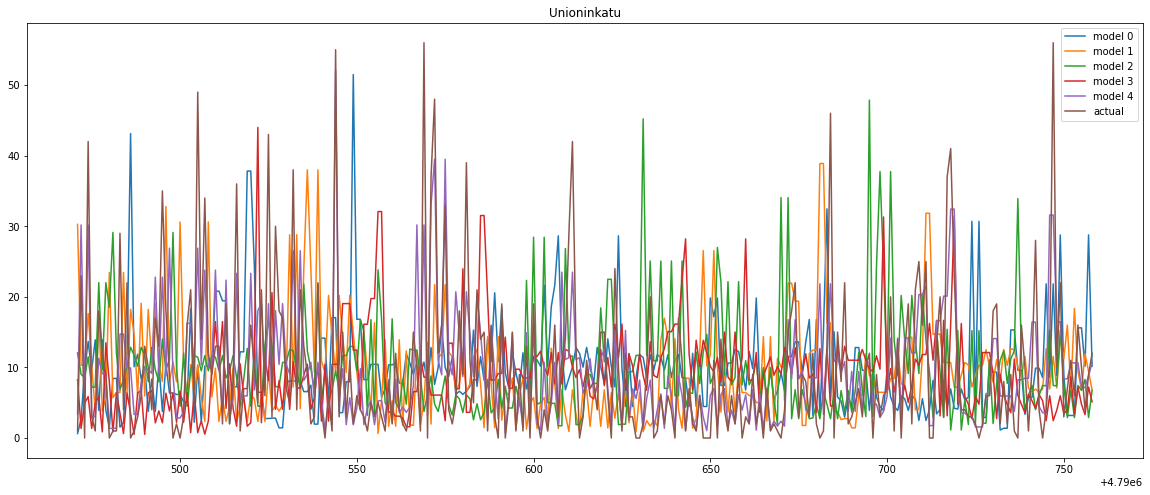

In [17]:
# plot predictions
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,8)

for i, prediction in enumerate(predictions_indexed):
    plt.plot(prediction, label=f"model {i}")

plt.plot(y_test, label="actual")
plt.legend()
plt.title(names_ids[11])
plt.show()

In [18]:
import pickle
pickle.dump(model, open("model.pkl", "wb"))